## Requirements

In [1]:
pip install poetry

Note: you may need to restart the kernel to use updated packages.


In [2]:
import mlflow

## Load Data

In [3]:
import pandas as pd

df_train = pd.read_excel("../datasets/processed/processed_train_car_data.xlsx")
df_train.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats,Price (INR Lakhs),Brand_Model_Encoded
0,Chennai,2011,10.687412,Diesel,Automatic,1,2.721953,5.318120,5.0,14.331324,8
1,Mumbai,2017,10.906708,Diesel,Manual,0,2.895912,5.141664,5.0,14.372266,1
2,Hyderabad,2009,11.957977,Diesel,Manual,0,2.624669,4.634729,8.0,13.652993,7
3,Mumbai,2010,11.050906,Other,Manual,1,2.438863,4.934474,5.0,12.721889,1
4,Mumbai,2019,10.906708,Petrol,Manual,0,2.950735,4.475062,5.0,13.429850,1


In [4]:
df_unseen = pd.read_excel("../datasets/processed/processed_unseen_car_data.xlsx")
df_unseen.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats,Price (INR Lakhs),Brand_Model_Encoded
0,Pune,2012,11.736077,Diesel,Automatic,0,2.525729,5.135798,7.0,14.115616,6
1,Delhi,2014,10.217057,Diesel,Manual,0,3.380995,4.317488,5.0,13.071072,45
2,Jaipur,2012,11.289794,Diesel,Manual,0,3.173878,4.317488,5.0,12.959847,45
3,Pune,2017,10.463132,Diesel,Automatic,0,2.939162,4.919981,5.0,14.669926,2
4,Chennai,2009,11.002117,Diesel,Manual,0,2.772589,4.663439,5.0,12.899222,1


## Setup

**Note:** I've done most of the preprocessing required on the dataset in the EDA file. Preprocessing includes outlier removal with interquartile range (IQR), logging values (with log1p), removing and converting units and encoding categorical variables.

#### Why I did not use PyCaret for these operations

1. Categorical Encoding:
Encoding Categorical Variables is possible for one hot encoding, but frequency and label encoding isnt supported, so I just manually did all the encoding in EDA (except one hot encoding). Frequency encoding is required for `Brand_Model`, as it has 1876 unique values, and one hot encoding would have caused high dimensionality.

2. Unit Conversion:
PyCaret also does not natively support converting units like `km/kg` to `kmpl`.

3. Outlier Removal and Log Transformation:
IQR for outlier removal was done to remove outliers was required to efficiently do logging. The reason why I chose to manually do this preprocessing step is because setting transformation = True in PyCaret still outputted skewed data, which is not ideal

One preprocessing step I did do when setting up is to impute values for missing data.

**To ensure that the model works without these preprocessing techniques in the PyCaret pipeline, I will simply pass clean input data that I want to predict in the deployed pipeline.**

In [5]:
from pycaret.regression import *
import hydra
from omegaconf import DictConfig
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra

def main(df_train):
    # Clear the Hydra instance
    GlobalHydra.instance().clear()
    
    # Initialize Hydra, without automatic argument parsing for Jupyter
    initialize(config_path="../configs", job_name="regression_pipeline")
    
    # Load the configuration
    cfg = compose(config_name="config")
    
    # Extract configuration from the Hydra config file
    categorical_features = cfg.experiment.categorical_features
    target = cfg.experiment.target
    remove_outliers = cfg.experiment.remove_outliers
    session_id = cfg.experiment.session_id
    imputation_type = cfg.experiment.imputation_type
    numeric_imputation = cfg.experiment.numeric_imputation
    categorical_imputation = cfg.experiment.categorical_imputation
    normalize = cfg.experiment.normalize
    log_experiment = cfg.experiment.log_experiment
    experiment_name = cfg.experiment.experiment_name
    
    # Set up PyCaret with these dynamic parameters
    reg = setup(data=df_train,
                target=target,
                remove_outliers=remove_outliers,
                session_id=session_id,
                imputation_type=imputation_type,
                numeric_imputation=numeric_imputation,
                categorical_imputation=categorical_imputation,
                normalize=normalize,
                log_experiment=log_experiment,
                experiment_name=experiment_name,
                categorical_features=categorical_features)
    
    return reg

reg = main(df_train)

,Description,Value
0,Session id,123
1,Target,Price (INR Lakhs)
2,Target type,Regression
3,Original data shape,"(5417, 11)"
4,Transformed data shape,"(5227, 23)"
5,Transformed train set shape,"(3601, 23)"
6,Transformed test set shape,"(1626, 23)"
7,Numeric features,7
8,Categorical features,3
9,Rows with missing values,0.8%


2025/03/01 17:08:57 INFO mlflow.tracking.fluent: Experiment with name 'experiment1' does not exist. Creating a new experiment.


## Data Understanding

In [6]:
transformed_df = get_config('dataset_transformed')
transformed_df.head()

,Location_Coimbatore,Location_Hyderabad,Location_Pune,Location_Jaipur,Location_Delhi,Location_Mumbai,Location_Chennai,Location_Bangalore,Location_Kochi,Location_Kolkata,...,Fuel_Type_Petrol,Fuel_Type_Diesel,Fuel_Type_Other,Transmission,Owner_Type,Mileage,Power,Seats,Brand_Model_Encoded,Price (INR Lakhs)
3293,2.793636,-0.386968,-0.328115,-0.270783,-0.323421,-0.389337,-0.286978,-0.243781,-0.341958,-0.317626,...,1.069920,-1.069920,0.0,0.633378,-0.41433,0.199433,-0.579600,-0.339135,0.266947,13.096022
1259,-0.357956,2.584190,-0.328115,-0.270783,-0.323421,-0.389337,-0.286978,-0.243781,-0.341958,-0.317626,...,-0.934649,0.934649,0.0,0.633378,-0.41433,0.462996,-1.052146,-0.339135,0.953900,12.765692
1685,-0.357956,-0.386968,3.047716,-0.270783,-0.323421,-0.389337,-0.286978,-0.243781,-0.341958,-0.317626,...,1.069920,-1.069920,0.0,0.633378,-0.41433,0.908639,-1.595081,-0.339135,-0.648990,12.472280
957,2.793636,-0.386968,-0.328115,-0.270783,-0.323421,-0.389337,-0.286978,-0.243781,-0.341958,-0.317626,...,1.069920,-1.069920,0.0,0.633378,-0.41433,0.392510,-2.032689,-0.339135,1.411869,12.570719
2671,-0.357956,-0.386968,-0.328115,3.692995,-0.323421,-0.389337,-0.286978,-0.243781,-0.341958,-0.317626,...,-0.934649,0.934649,0.0,0.633378,-0.41433,0.296922,-0.841371,-0.339135,0.839408,12.765692


In [7]:
missing_values = transformed_df.isnull().sum()
missing_percentage = (missing_values / len(transformed_df)) * 100

missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)

missing_df #Double Checking for missing values

,Missing Values,Percentage (%)


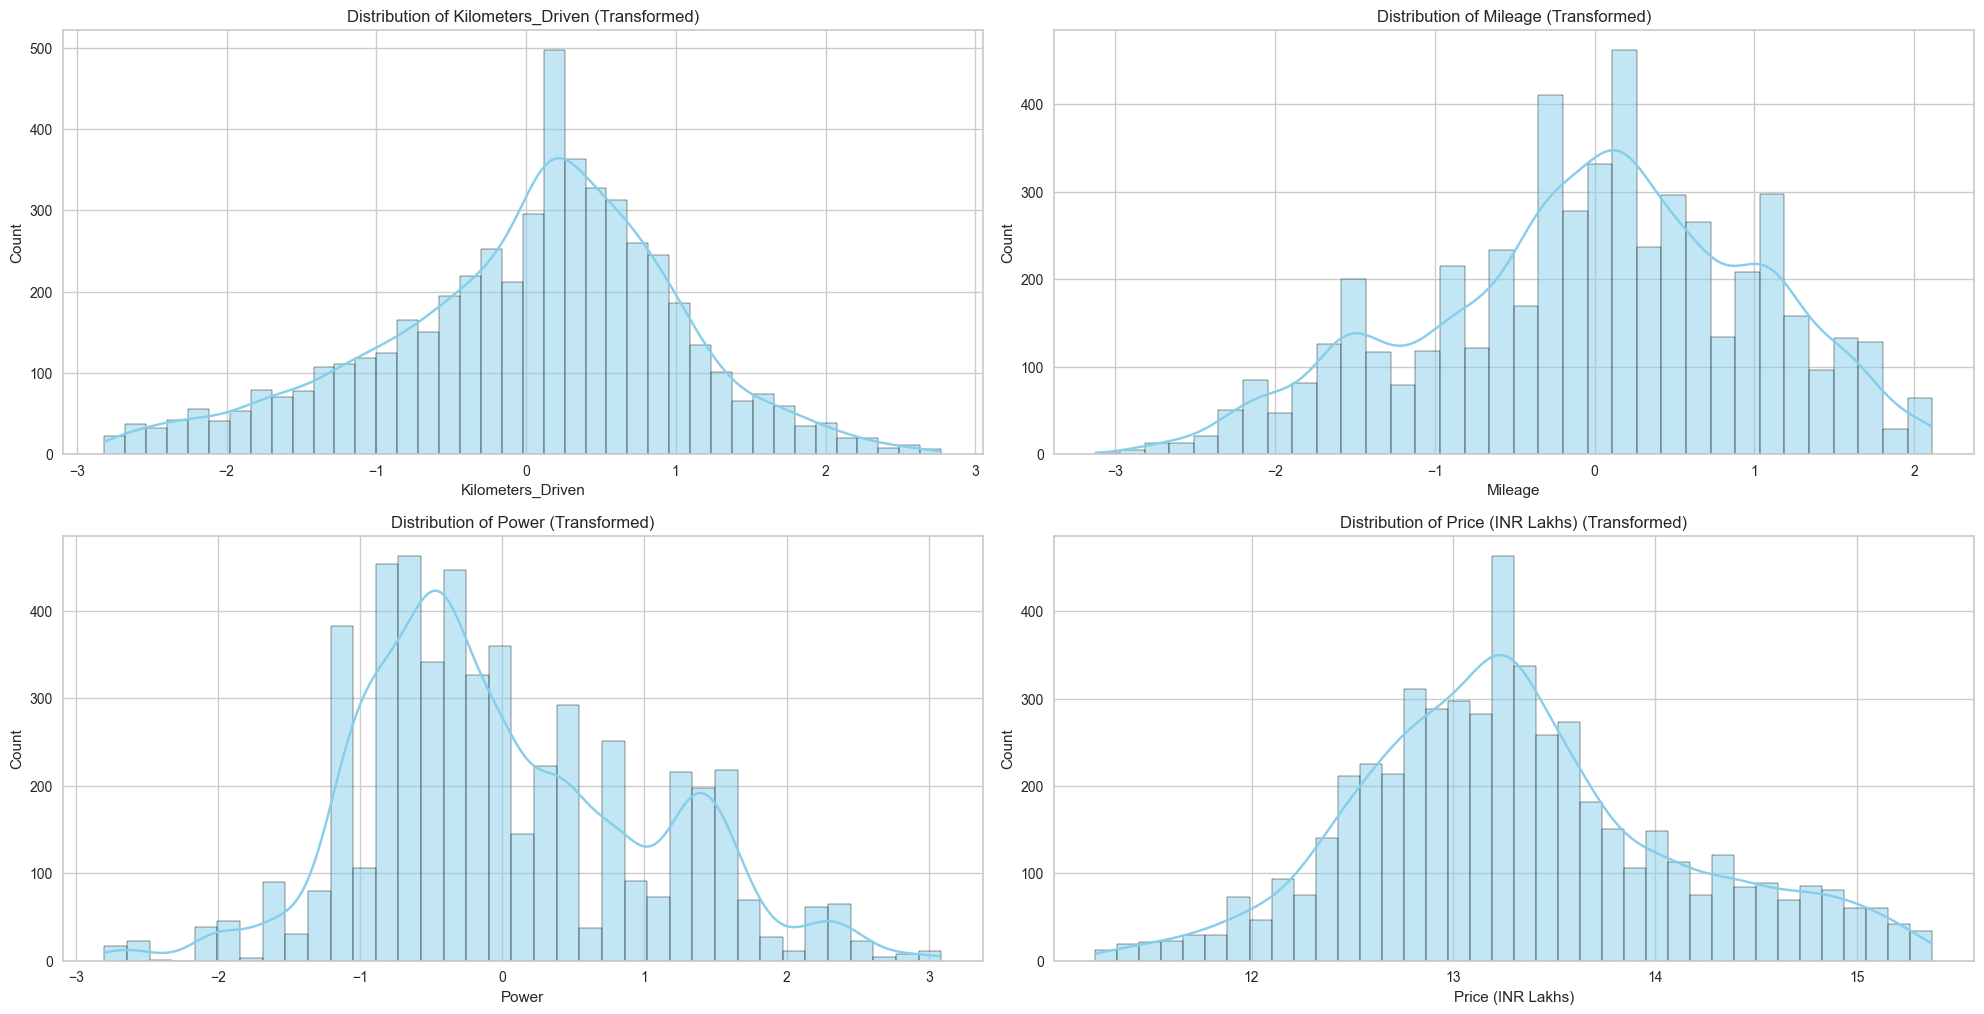

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = ['Kilometers_Driven', 'Mileage', 'Power', 'Price (INR Lakhs)']

plt.figure(figsize=(20, 20))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(transformed_df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col} (Transformed)')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

The distributions look intact from the manual cleaning and normally distributed, with minor, negligible skewing. The normalisation has also properly been completed.

In [9]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.1847,0.0902,0.2982,0.8588,0.0206,0.0138,1.0600
lightgbm,Light Gradient Boosting Machine,0.1957,0.0988,0.3123,0.8454,0.0216,0.0146,0.6080
xgboost,Extreme Gradient Boosting,0.1904,0.0993,0.3127,0.8448,0.0217,0.0143,0.3360
rf,Random Forest Regressor,0.1989,0.1023,0.3177,0.8399,0.0220,0.0149,0.2420
et,Extra Trees Regressor,0.1977,0.1027,0.3183,0.8395,0.0221,0.0148,0.2030
gbr,Gradient Boosting Regressor,0.2204,0.1127,0.3345,0.8239,0.0231,0.0165,0.1070
br,Bayesian Ridge,0.2627,0.1619,0.4018,0.7467,0.0277,0.0196,0.0470
ridge,Ridge Regression,0.2626,0.1620,0.4019,0.7465,0.0278,0.0196,0.0480
lar,Least Angle Regression,0.2626,0.1620,0.4019,0.7464,0.0278,0.0196,0.0500
lr,Linear Regression,0.2630,0.1623,0.4023,0.7461,0.0278,0.0197,0.6930


2025/03/01 17:09:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/01 17:09:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/01 17:09:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/01 17:09:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/01 17:09:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/01 17:09:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when

In [10]:
import numpy as np

logged_mae = 0.1847
logged_rmse = 0.2982

relative_mae = np.expm1(logged_mae)
relative_rmse = np.expm1(logged_rmse)

print(f"MAE (% of true value): {relative_mae * 100:.2f}%")
print(f"RMSE (% of true value): {relative_rmse * 100:.2f}%")

MAE (% of true value): 20.29%
RMSE (% of true value): 34.74%


The **CatBoost Regressor** achieved an R² of 0.859, with a Mean Absolute Error (MAE) of 0.1847 in log-transformed space. When reversed to the original scale, the MAE reflects an average prediction error of **20.29%** relative to the true car prices.

This means that, on average, the model’s predictions are 20.23% higher or lower than the actual car prices. For example, if a car is worth ₹10 lakhs, the predicted price would typically deviate by around ₹2 lakhs (20.23%), whether above or below the true value.

Similarly, the Root Mean Squared Error (RMSE), which penalises larger errors more heavily, translates to a **34.7%** deviation. This suggests that while most predictions are within the 20% range, some outliers cause greater deviations.

Since both metrics are presented as relative percentages, they are independent of specific currency values and provide a scale-free measure of the model’s predictive accuracy. A 20% average error is reasonably acceptable in the context of used car pricing, where variations are common due to subjective factors like condition, demand, and negotiation.

## Hyperparameter Tuning

In [11]:
tuned_model = tune_model(best, optimize='R2', fold=20)

evaluate_model(tuned_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2010,0.1001,0.3164,0.8616,0.0215,0.0149
1,0.2030,0.1223,0.3497,0.7949,0.0243,0.0152
2,0.2021,0.1082,0.3289,0.8162,0.0225,0.0151
3,0.1812,0.0857,0.2928,0.8793,0.0206,0.0136
4,0.2284,0.1417,0.3764,0.8109,0.0254,0.0168
5,0.1706,0.0902,0.3003,0.8517,0.0202,0.0125
6,0.1751,0.0742,0.2725,0.8723,0.0190,0.0133
7,0.1767,0.0837,0.2894,0.8724,0.0201,0.0135
8,0.1842,0.0747,0.2733,0.8895,0.0190,0.0139


Fitting 20 folds for each of 10 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


2025/03/01 17:10:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

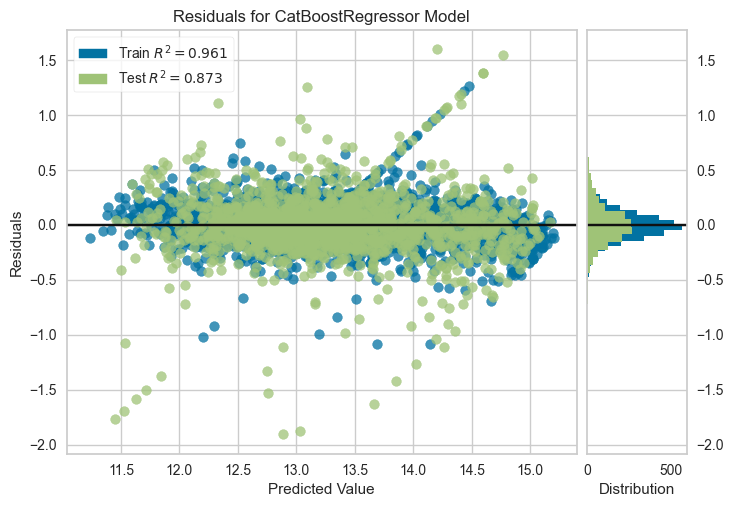

In [12]:
plot_model(tuned_model, plot = 'residuals')

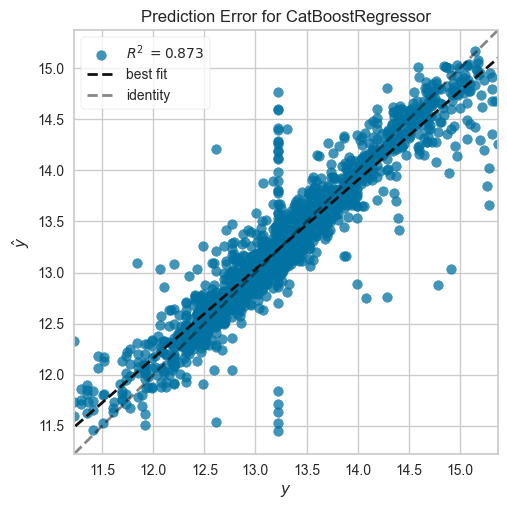

In [13]:
# plot error
plot_model(tuned_model, plot = 'error')

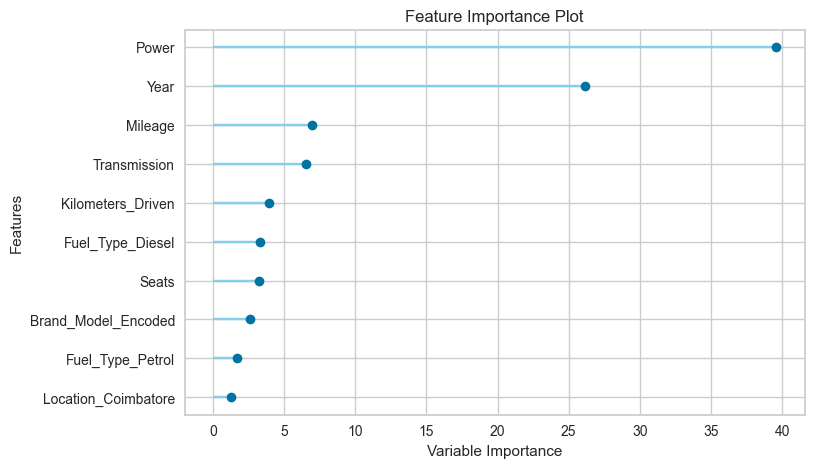

In [14]:
plot_model(tuned_model, plot = 'feature')

In [15]:
final_model = finalize_model(tuned_model)

2025/03/01 17:11:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [16]:
save_model(final_model, "../experiments/car_price_pipeline")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Year', 'Kilometers_Driven',
                                              'Owner_Type', 'Mileage', 'Power',
                                              'Seats', 'Brand_Model_Encoded'],
                                     transformer=SimpleImputer(strategy='median'))),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Location', 'Fuel_Type', 'Transmission'],
                                     transformer=SimpleImputer(stra...
                                                               handle_missing='return_nan',
                                                               use_cat_names=True))),
                 ('remove_outliers',
                  TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('c

In [17]:
unseen_predictions = predict_model(final_model, data=df_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.1797,0.0930,0.3050,0.8622,0.0211,0.0135


,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Power,Seats,Brand_Model_Encoded,Price (INR Lakhs),prediction_label
0,Pune,2012,11.736077,Diesel,Automatic,0,2.525729,5.135798,7.0,6,14.115616,14.087871
1,Delhi,2014,10.217056,Diesel,Manual,0,3.380995,4.317488,5.0,45,13.071073,13.171608
2,Jaipur,2012,11.289794,Diesel,Manual,0,3.173878,4.317488,5.0,45,12.959846,12.887385
3,Pune,2017,10.463132,Diesel,Automatic,0,2.939162,4.919981,5.0,2,14.669927,14.612002
4,Chennai,2009,11.002116,Diesel,Manual,0,2.772589,4.663439,5.0,1,12.899222,12.751192


In [18]:
final_model = load_model('../experiments/car_price_pipeline')

Transformation Pipeline and Model Successfully Loaded


In [20]:
if mlflow.active_run():
    mlflow.end_run()

print("All active MLflow runs are closed.")

All active MLflow runs are closed.


In [21]:
with mlflow.start_run(run_name="car_price_pipeline"):
    mlflow.log_artifact("../experiments/car_price_pipeline.pkl")
    mlflow.log_param("Model", "CatBoost Regressor")

    mlflow.log_metric("MAE", 0.1847)
    mlflow.log_metric("MSE", 0.0902)
    mlflow.log_metric("RMSE", 0.2982)
    mlflow.log_metric("R2", 0.8588)

    # Save the trained CatBoost model
    mlflow.sklearn.log_model(best, "catboost_model")

2025/03/01 17:11:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [ ]:
!mlflow ui

In [ ]:
# import mlflow.pyfunc

# model_uri = f"runs:/<your_run_id>/car_price_pipeline.pkl"
# loaded_model = mlflow.pyfunc.load_model(model_uri)

# # Example prediction
# predictions = loaded_model.predict(unseen_df)
# print(predictions)